In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import numpy as np
from astropy.time import Time
import astropy.units as u
from astropy.utils.console import ProgressBar

from rms import STSP, Star, Spot, Planet

In [2]:
t0 = 2454954.357463
rotation_period = 25
inc_stellar = -20

transit_times = Time(t0, format='jd') + np.arange(-3/24, 3/24, 1/60/24) * u.day

planet = Planet.from_hat7()
planet.lam = 90

star = Star(planet=planet, rotation_period=rotation_period, 
            inc_stellar=inc_stellar)

In [3]:
for attr in dir(star):
    if not attr.startswith('_'):
        print(attr, getattr(star, attr))
        
for attr in dir(planet):
    if not attr.startswith('_'):
        print(attr, getattr(planet, attr))

inc_stellar -20
per_rot 25
planet <rms.planet.Planet object at 0x1119ac208>
spot_contrast 0.7
a 4.1502
b 0.5002125407344931
duration 0.12813004872191647
ecc 0.0
from_hat11 <bound method Planet.from_hat11 of <class 'rms.planet.Planet'>>
from_hat7 <bound method Planet.from_hat7 of <class 'rms.planet.Planet'>>
inc 83.111
lam 90
limb_dark quadratic
per 2.204737
rp 0.058330305324663184
t0 2454954.357463
u [0.3525, 0.168]
w 0.0


In [4]:
n_transits = 100
fluxes = np.zeros((len(transit_times), n_transits))
times = np.zeros((len(transit_times), n_transits))

no_transit_spot = Spot(radius=0.0001, latitude=-88*u.deg, longitude=0*u.deg)

i = 0
with ProgressBar(n_transits, ipython_widget=True) as bar:
    while i < n_transits:
        
        # Draw spots from the sunspot distribution
        n_spots = 50
        spots = [Spot.from_sunspot_distribution(mean_latitude=20) for i in range(n_spots)]

        # Draw observing times from uniform distribution
        random_times = transit_times + 1 * (np.random.rand() - 0.5) * u.min
        
        with STSP(random_times, star, spots, quiet=True) as stsp: 
            lc = stsp.generate_lightcurve(n_ld_rings=100)
            
        with STSP(random_times, star, no_transit_spot, quiet=True) as stsp: 
            no_spot_lc = stsp.generate_lightcurve(n_ld_rings=100)

        # If STSP ran successfully: 
        f_test = lc.fluxes if not hasattr(lc.fluxes, 'value') else lc.fluxes.value

        if not np.any(np.isnan(lc.fluxes)):
            oot = lc.mask_out_of_transit(star, flip=True)
            oot_fluxes = oot['fluxes']
            median_oot_flux = np.median(oot_fluxes)

            min_length = min([len(lc.fluxes), len(no_spot_lc.fluxes)])
            #fluxes[:, i] = lc.fluxes / median_oot_flux - no_spot_lc.fluxes
            fluxes[:, i] = lc.fluxes / median_oot_flux - no_spot_lc.fluxes
            times[:, i] = random_times.jd

#             # Remove linear polynomial to OOT
#             oot_mask = ((random_times.jd < t0 - planet.duration/2) | 
#                         (random_times.jd > t0 + planet.duration/2))
#             fit_params = np.polyfit(times[:, i][oot_mask] - 
#                                     times[:, i][oot_mask].mean(), 
#                                     fluxes[:, i][oot_mask], 1)
#             fluxes[:, i] -= np.polyval(fit_params, times[:, i] - times[:, i].mean())
    #         fluxes[:, i] -= np.median(fluxes[:, i][oot_mask])
            i += 1
            bar.update()

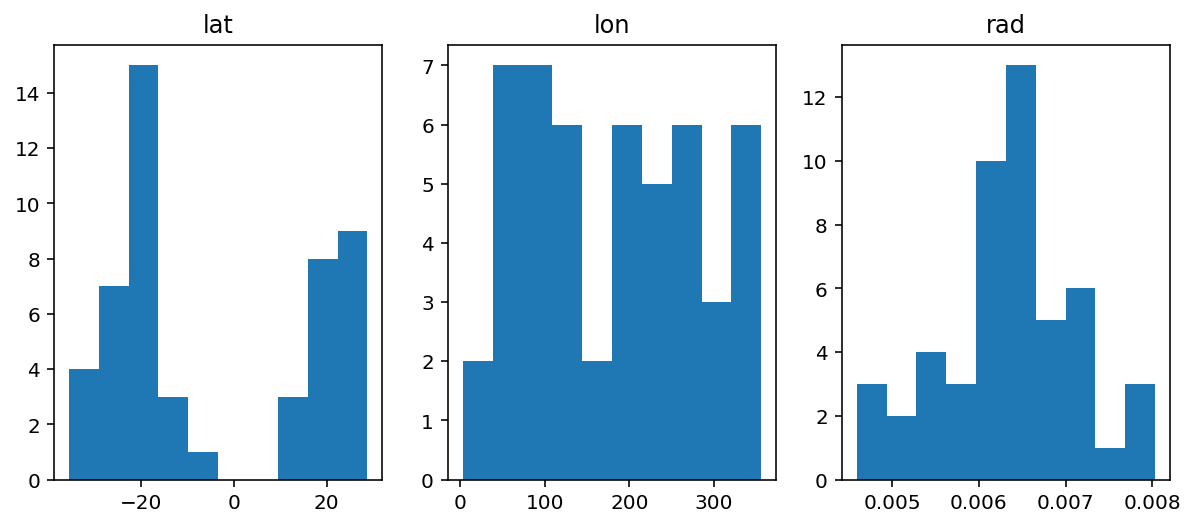

In [5]:
fig, ax = plt.subplots(1, 3, figsize=(10, 4))
ax[0].hist([s.latitude.to(u.deg).value for s in spots])
ax[0].set_title('lat')
ax[1].set_title('lon')
ax[1].hist([s.longitude.to(u.deg).value for s in spots])

ax[2].set_title("rad")
ax[2].hist([s.radius for s in spots])
plt.show()

[None, None, None, None, None, None, None, None, None, None, None, None]

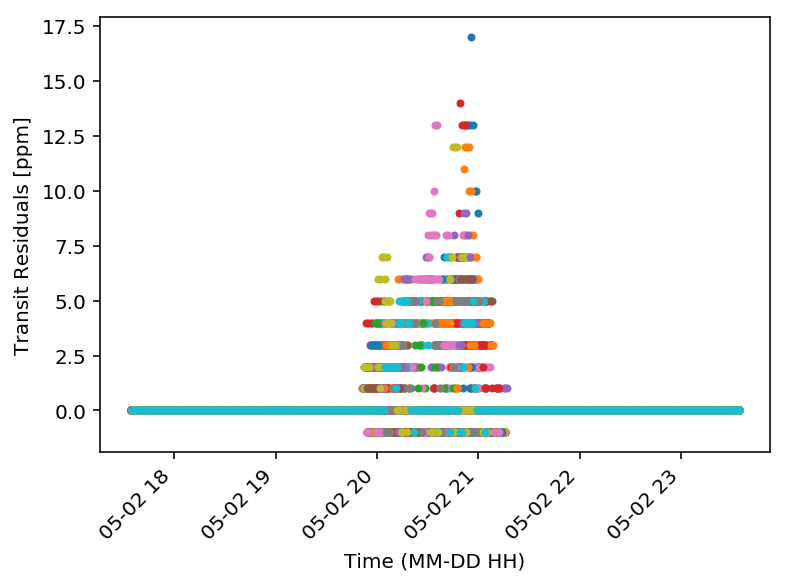

In [6]:
mf = np.median(fluxes, axis=1)

for t, f in zip(times.T, fluxes.T):    
    plt.plot_date(Time(t, format='jd').plot_date, f*1e6, fmt='.', alpha=1)#, color='k')
#plt.ylim([-0.003, 0.001])
ax = plt.gca()
ax.set(xlabel='Time (MM-DD HH)', ylabel='Transit Residuals [ppm]')
plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
#plt.savefig('sun_with_h11_residuals.png', bbox_inches='tight', dpi=150)

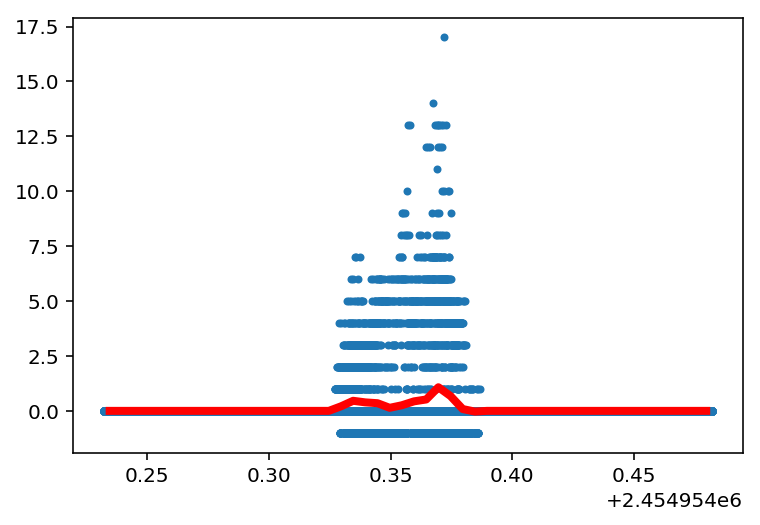

In [7]:
from scipy.ndimage import gaussian_filter1d
from scipy.stats import binned_statistic

t, f = times.ravel(), fluxes.ravel()
f = f[np.argsort(t)]
t = t[np.argsort(t)]

bs = binned_statistic(t, f, statistic='mean', bins=50)
bincenters = 0.5*(bs.bin_edges[1:] + bs.bin_edges[:-1])
plt.plot(t, 1e6*f, '.')
plt.plot(bincenters, 1e6*bs.statistic, 'r', lw=4)
#plt.plot(t, gaussian_filter1d(f, 50), lw=4)